In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
import pandas as pd
import random
import math
from collections import Counter
flatten = lambda l: [item for sublist in RowsAsList for item in sublist]

import torch
import torchvision
import os
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torchvision.utils import save_image
import time

In [2]:
USE_CUDA = torch.cuda.is_available()
#gpus = [0]
#torch.cuda.set_device(gpus[0])

FloatTensor = torch.cuda.FloatTensor if USE_CUDA else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if USE_CUDA else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if USE_CUDA else torch.ByteTensor

In [3]:
def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return Variable(LongTensor(idxs))

def prepare_word(word, word2index):
    return Variable(LongTensor([word2index[word]]) if word2index.get(word) is not None else LongTensor([word2index["<UNK>"]]))

## Let's assume these are Article Numbers, seen in this order - different articles and different length of sequences

In [4]:
RowsAsList = [['936751',
  '937847',
  '934619',
  '965087',
  '928416',
  '926887',
  '937046',
  '918311',
  '929940',
  '969736',
  '927736',
  '915727',
  '904645',
  '945575',
  '971332',
  '921676',
  '936763',
  '928940',
  '907681',
  '917145'],
 ['945575',
  '927135',
  '967963',
  '979403',
  '904713',
  '946313',
  '941984',
  '978130'],
 ['969587',
  '976817',
  '973131',
  '957345',
  '944981',
  '913876',
  '905890',
  '969418',
  '910574',
  '941952']]

In [5]:
vocab = list(set(flatten(RowsAsList)))
vocab.insert(0,'<UNK>')

n_vocab = len(vocab)

word2index = {'<UNK>' : 0} 

for vo in vocab:
    if word2index.get(vo) is None:
        word2index[vo] = len(word2index)

index2word = {v:k for k, v in word2index.items()} 


In [6]:
len(RowsAsList[0]), len(RowsAsList[1])

(20, 8)

In [7]:
vocab[:4], len(vocab)

(['<UNK>', '936763', '907681', '957345'], 38)

In [8]:
# Find letter index from vocab, e.g. "936751" = 1
def artToIndex(art):
    return word2index.get(art)

# Just for demonstration, turn a article into a <1 x n_articles> Tensor
def artToTensor(art):
    tensor = torch.zeros(1, n_vocab)
    #tensor = torch.zeros(1, n_vocab, device=torch.device("cuda")) # use if cuda is available
    tensor[0][artToIndex(art)] = 1
    return tensor

# Turn a list into a <line_length x 1 x n_letters>,
# or an array of one-hot article vectors
def listToTensor(list):
    tensor = torch.zeros(len(list), 1, n_vocab)
    #tensor = torch.zeros(len(list), 1, n_vocab, device=torch.device("cuda")) # use if cuda is available
    for element, art in enumerate(list):
        tensor[element][0][artToIndex(art)] = 1
    return tensor

# Modelling

In [9]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        
        self.i2i = nn.Linear(input_size + hidden_size, input_size + hidden_size)
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.o2o = nn.Linear(output_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        combined_2 = F.selu(self.i2i(combined))
        hidden = self.i2h(combined_2)
        hidden = F.selu(self.h2h(hidden))
        output = self.i2o(combined_2)
        output = F.selu(self.o2o(output))
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
        #return torch.zeros(1, self.hidden_size, device=torch.device("cuda")) # use if cuda is available

n_hidden = 256
rnn = RNN(n_vocab, n_hidden, n_vocab)
if USE_CUDA:
    rnn = rnn.cuda()

In [10]:
next(rnn.parameters()).is_cuda

False

Output is the length of the vocabulary, each element represents an article

In [11]:
# output ist n_vocab
input = listToTensor(['913876', '945575'])
hidden = torch.zeros(1, n_hidden)
#hidden = torch.zeros(1, n_hidden, device=torch.device("cuda")) # use if cuda is available

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-3.5384, -3.6551, -3.5802, -3.5122, -3.5349, -3.6164, -3.5004, -3.6654,
         -3.6797, -3.6035, -3.7158, -3.7371, -3.9135, -3.9631, -3.4402, -3.4510,
         -3.8530, -3.6993, -3.6922, -3.7861, -3.5827, -3.7543, -3.4412, -3.7842,
         -3.5253, -3.7949, -3.5194, -3.7577, -3.4973, -3.6153, -3.5648, -3.7756,
         -3.5411, -3.8074, -3.8347, -3.6627, -3.5264, -3.4578]],
       grad_fn=<LogSoftmaxBackward>)


# Helper Functions

In [12]:
def artFromOutput(output):
    top_n, top_i = output.topk(1)
    art_i = top_i[0].item()
    return vocab[art_i], art_i

print(artFromOutput(output))

('928940', 14)


In [13]:
def Convert(string): 
    li = list(string.split(", ")) 
    return li

Create randomTrainingExample to use as a batch in training. Use sequence to decide how many articles to use to predict next article.

In [14]:
seq_length = 3

def randomChoice(l):
    rand_nr = random.randint(0, len(l) - 1)
    return l[rand_nr]

def randomTrainingExample():
    random_session = randomChoice(RowsAsList)
    session_len = len(random_session)
    random_i = random.randint(0, session_len - 1 - seq_length)
    inputs = listToTensor(random_session[random_i:random_i+seq_length])
    targets = torch.argmax(listToTensor(Convert(random_session[random_i+seq_length])))
    targets = torch.tensor([targets], dtype=torch.long)
    #targets = torch.tensor([targets], dtype=torch.long, device=torch.device("cuda")) # use if cuda available
    return random_session, random_i, inputs, targets

In [15]:
random_session, random_i, inputs, targets = randomTrainingExample()

In [16]:
random_session

['936751',
 '937847',
 '934619',
 '965087',
 '928416',
 '926887',
 '937046',
 '918311',
 '929940',
 '969736',
 '927736',
 '915727',
 '904645',
 '945575',
 '971332',
 '921676',
 '936763',
 '928940',
 '907681',
 '917145']

In [17]:
random_i

15

In [18]:
inputs

tensor([[[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.]]])

In [19]:
targets

tensor([2])

In [21]:
vocab[2]

'907681'

# Define Training

In [22]:
# Loss function
criterion = nn.NLLLoss()

In [23]:
def train(targets, inputs):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(inputs.size()[0]):
        output, hidden = rnn(inputs[i], hidden)

    loss = criterion(output, targets)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate - SGD
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [24]:
learning_rate = 0.01 # If you set this too high, it might explode. If too low, it might not learn

n_iters = 1000
print_every = 50
plot_every = 10
SEQ_LENGTH = 3


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    random_session, random_i, inputs, targets = randomTrainingExample()
    output, loss = train(targets, inputs)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        print('%d %d%% (%s) %.4f  ' % (iter, iter / n_iters * 100, timeSince(start), loss ))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

50 5% (0m 0s) 3.4325  
100 10% (0m 0s) 3.5693  
150 15% (0m 1s) 3.3120  
200 20% (0m 1s) 3.1850  
250 25% (0m 1s) 3.1806  
300 30% (0m 1s) 3.0596  
350 35% (0m 2s) 3.3713  
400 40% (0m 2s) 2.9930  
450 45% (0m 2s) 3.2633  
500 50% (0m 3s) 2.9150  
550 55% (0m 3s) 3.0499  
600 60% (0m 3s) 2.7465  
650 65% (0m 4s) 2.5413  
700 70% (0m 4s) 2.6569  
750 75% (0m 4s) 3.5253  
800 80% (0m 5s) 3.7490  
850 85% (0m 5s) 2.4161  
900 90% (0m 5s) 0.4724  
950 95% (0m 5s) 3.6187  
1000 100% (0m 6s) 1.0102  


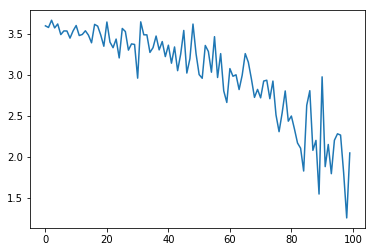

In [25]:
plt.figure()
plt.plot(all_losses)

In [32]:
learning_rate = 0.01 # If you set this too high, it might explode. If too low, it might not learn

n_iters = 1000
print_every = 50
plot_every = 10
SEQ_LENGTH = 3


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    random_session, random_i, inputs, targets = randomTrainingExample()
    output, loss = train(targets, inputs)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        print('%d %d%% (%s) %.4f  ' % (iter, iter / n_iters * 100, timeSince(start), loss ))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

50 5% (0m 0s) 2.8061  
100 10% (0m 0s) 0.2821  
150 15% (0m 0s) 0.1563  
200 20% (0m 1s) 0.0331  
250 25% (0m 1s) 0.0820  
300 30% (0m 1s) 0.0476  
350 35% (0m 2s) 3.2287  
400 40% (0m 2s) 0.0441  
450 45% (0m 2s) 0.0218  
500 50% (0m 3s) 0.2762  
550 55% (0m 3s) 0.0123  
600 60% (0m 3s) 3.7747  
650 65% (0m 4s) 0.0374  
700 70% (0m 4s) 0.0231  
750 75% (0m 4s) 0.9519  
800 80% (0m 5s) 0.0139  
850 85% (0m 5s) 0.8933  
900 90% (0m 5s) 0.0053  
950 95% (0m 5s) 0.0024  
1000 100% (0m 6s) 0.0086  


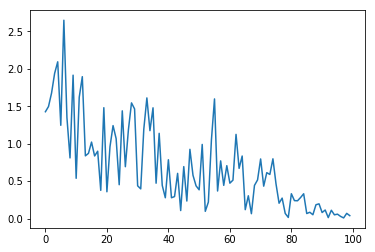

In [33]:
plt.figure()
plt.plot(all_losses)

In [34]:
def evaluate(seq_tensor):
    hidden = rnn.initHidden()

    for i in range(seq_tensor.size()[0]):
        output, hidden = rnn(seq_tensor[i], hidden)

    return output

In [35]:
def predict(artnr, n_predictions=3):
    print('\n> %s' % artnr)
    with torch.no_grad():
        output = evaluate(listToTensor(artnr))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            artnr_index = topi[0][i].item()
            print('(%.2f) %s' % (value, vocab[artnr_index]))
            predictions.append([value, vocab[artnr_index]])

In [37]:
predict(['928416','918311','929940'])
predict(['936763','928940','907681'])
predict(['936751','937847','934619'])


> ['928416', '918311', '929940']
(-0.17) 918311
(-3.12) 927736
(-3.77) 928416

> ['936763', '928940', '907681']
(-0.24) 917145
(-2.09) 929940
(-3.76) 927736

> ['936751', '937847', '934619']
(-0.04) 965087
(-4.65) 945575
(-4.66) 913876


In [28]:
(RowsAsList[0])

['936751',
 '937847',
 '934619',
 '965087',
 '928416',
 '926887',
 '937046',
 '918311',
 '929940',
 '969736',
 '927736',
 '915727',
 '904645',
 '945575',
 '971332',
 '921676',
 '936763',
 '928940',
 '907681',
 '917145']

also works for fewer sequences then 3

In [39]:
predict(['937046','918311'])


> ['937046', '918311']
(-1.39) 929940
(-2.09) 927736
(-2.25) 917145
